# FEV vs. Alpha Analysis

For each SimCLR layer, this notebook plots **mean FEV** vs. **alpha** (where alpha is the slope of the log–log PCA variance spectrum).

- **Mean FEV** is taken from the regression: SimCLR features (reduced to N PCs) → PC1 Neural data

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

In [1]:
from cortexlib.power_law import PowerLawAlphaEstimator
from cortexlib.utils.file import read_json_file_as_dataframe, write_json_file
from cortexlib.utils.logging import Logger
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.plotting import simclr_colours
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import warnings
import torch

logger = Logger()
set_global_seed()

In [2]:
fev_results = read_json_file_as_dataframe('../regressions/results/simclr_feats_pcs_to_pc1_neural_data.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
44,fc,500.0,0.409388,0.432522
2,layer1,20.0,0.386545,0.408575
11,layer2,20.0,0.460803,0.486424
21,layer3,50.0,0.462780,0.488496
34,layer4,400.0,0.429101,0.453189


In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    simclr_data = torch.load('../regressions/features/simclr_features_all_layers.pt')

simclr_feats = simclr_data['features']

In [4]:
power_law_alpha_estimator = PowerLawAlphaEstimator()

alpha_results = []

logger.progress(f"Computing α for SimCLR features across layers")
for layer, feats in tqdm(simclr_feats.items(), desc="α for all SimCLR layers"):
    logger.progress(f"SimCLR {layer}")

    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    alpha = power_law_alpha_estimator.compute_alpha(feats)

    alpha_results.append({
        'layer': layer,
        'alpha': alpha['alpha'],
        'alpha_no_pc1': alpha['alpha_no_pc1'],
    })

logger.success(f"Alphas computed")

19:03:39 | INFO     | ⏳ Computing α for SimCLR features across layers...


α for all SimCLR layers:   0%|          | 0/5 [00:00<?, ?it/s]

19:03:40 | INFO     | ⏳ SimCLR layer1...


19:04:01 | INFO     | ⏳ SimCLR layer2...


19:04:09 | INFO     | ⏳ SimCLR layer3...


19:04:13 | INFO     | ⏳ SimCLR layer4...


19:04:16 | INFO     | ⏳ SimCLR fc...


19:04:16 | SUCCESS  | ✅ Alphas computed!


In [5]:
write_json_file(alpha_results, './results/alpha_simclr_feats_pcs_to_pc1_neural_data.json')

In [6]:
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df

,layer,alpha,alpha_no_pc1
0,layer1,3.757470,4.210595
1,layer2,3.465111,4.031078
2,layer3,1.888670,1.893514
3,layer4,1.879386,1.885806
4,fc,1.702589,1.713680


In [7]:
merged_results = pd.merge(best_fev_per_layer, alpha_results_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,alpha,alpha_no_pc1
0,fc,500.0,0.409388,0.432522,1.702589,1.713680
1,layer1,20.0,0.386545,0.408575,3.757470,4.210595
2,layer2,20.0,0.460803,0.486424,3.465111,4.031078
3,layer3,50.0,0.462780,0.488496,1.888670,1.893514
4,layer4,400.0,0.429101,0.453189,1.879386,1.885806


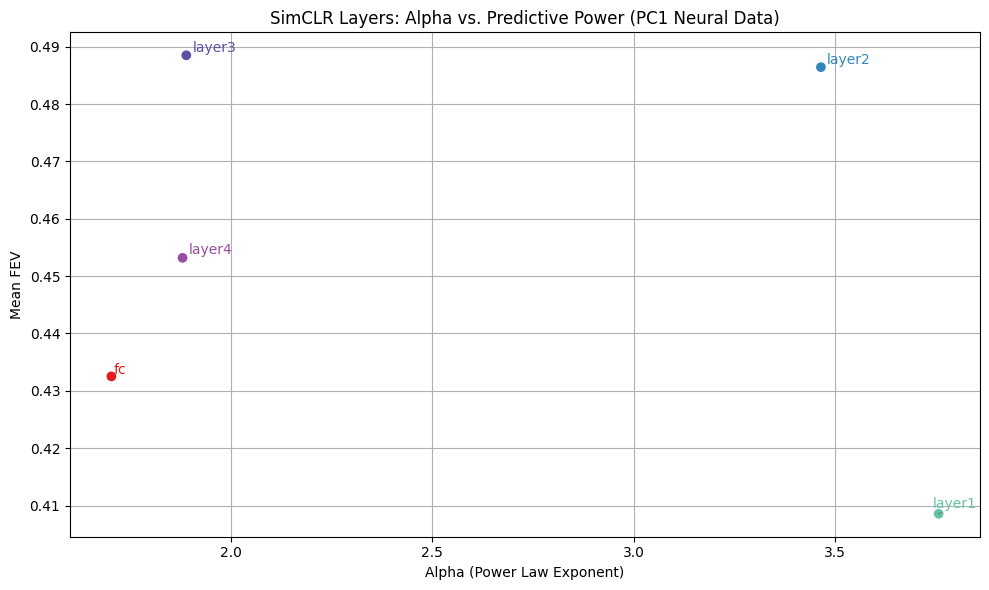

In [8]:
colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['alpha'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['alpha'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Alpha (Power Law Exponent)')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: Alpha vs. Predictive Power (PC1 Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()